   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

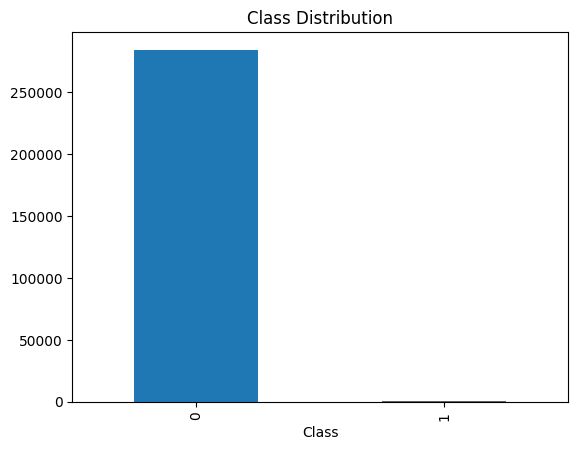

Training set class distribution:
 Class
0    0.998274
1    0.001726
Name: proportion, dtype: float64

Validation set class distribution:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

Testing set class distribution:
 Class
0    0.998262
1    0.001738
Name: proportion, dtype: float64
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Grid Search Execution Time: 660.50 seconds
Best Parameters from GridSearchCV: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best AUPRC from GridSearchCV: 0.8452492917742186

Tuned Model Confusion Matrix:
 [[56858     5]
 [   29    69]]

Tuned Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.70      0.80        98

    accuracy                           1.00     56961
   macro avg       0.97      0.85      0.90     56961
weighted avg       1.00 

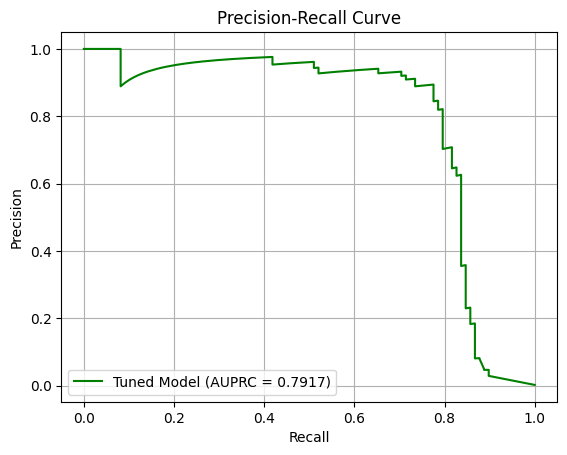


Confusion Matrix with Adjusted Threshold:
 [[56843    20]
 [   20    78]]

Classification Report with Adjusted Threshold:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.80      0.80      0.80        98

    accuracy                           1.00     56961
   macro avg       0.90      0.90      0.90     56961
weighted avg       1.00      1.00      1.00     56961


Test Set Confusion Matrix (Adjusted Threshold):
 [[56847    16]
 [   15    84]]

Test Set Classification Report (Adjusted Threshold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.84      0.85      0.84        99

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import time

#Reduced Threshold, SMOTE removed

# File path for the dataset (Google Colab path)
file_path = '/content/drive/MyDrive/AppliedAIDataset/creditcard.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows
print(data.head())

# Check data summary
print(data.info())

# Check class imbalance
print(data['Class'].value_counts())

# Plotting the imbalance data
data['Class'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

# Separate features (X) and target (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Step 1: Split into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# Step 2: Split temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Verify the splits
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation set class distribution:\n", y_val.value_counts(normalize=True))
print("\nTesting set class distribution:\n", y_test.value_counts(normalize=True))

# Normalize feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [200],
    'max_depth': [20],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'class_weight': ['balanced']
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV for Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='average_precision',  # Optimize for AUPRC
    n_jobs=-1,
    verbose=3
)

# Track execution time
start_time = time.time()

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Track execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Grid Search Execution Time: {execution_time:.2f} seconds")

# Log best parameters and performance
print("Best Parameters from GridSearchCV:", grid_search.best_params_)
print("Best AUPRC from GridSearchCV:", grid_search.best_score_)

# Evaluate the best model on the validation data
best_rf_model = grid_search.best_estimator_
y_val_pred = best_rf_model.predict(X_val_scaled)
y_val_proba = best_rf_model.predict_proba(X_val_scaled)[:, 1]

# Confusion Matrix and Classification Report
print("\nTuned Model Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nTuned Model Classification Report:\n", classification_report(y_val, y_val_pred))

# ROC-AUC and AUPRC
roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"Tuned Model ROC-AUC Score: {roc_auc:.4f}")
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
tuned_auprc = auc(recall, precision)
print(f"Tuned Model AUPRC: {tuned_auprc:.4f}")

# Plot Precision-Recall Curve
plt.plot(recall, precision, label=f"Tuned Model (AUPRC = {tuned_auprc:.4f})", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Adjust Decision Threshold
optimal_threshold = 0.2  # Lower threshold to prioritize recall
y_val_pred_adjusted = (y_val_proba >= optimal_threshold).astype(int)

# Confusion Matrix and Classification Report for Adjusted Threshold
print("\nConfusion Matrix with Adjusted Threshold:\n", confusion_matrix(y_val, y_val_pred_adjusted))
print("\nClassification Report with Adjusted Threshold:\n", classification_report(y_val, y_val_pred_adjusted))

# Test the tuned model on the test set
y_test_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred_adjusted = (y_test_proba >= optimal_threshold).astype(int)

# Test Set Evaluation with Adjusted Threshold
print("\nTest Set Confusion Matrix (Adjusted Threshold):\n", confusion_matrix(y_test, y_test_pred_adjusted))
print("\nTest Set Classification Report (Adjusted Threshold):\n", classification_report(y_test, y_test_pred_adjusted))


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

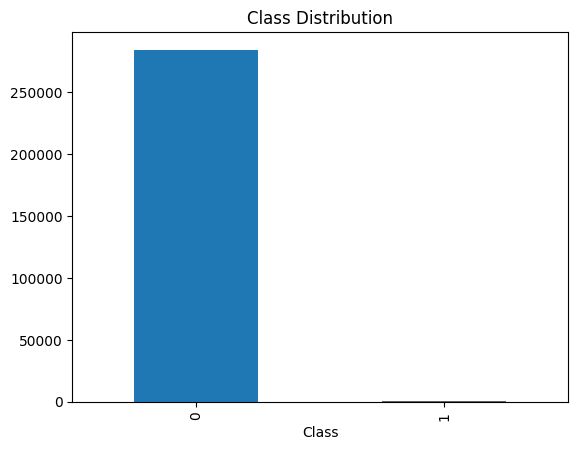

Training set class distribution:
 Class
0    0.998274
1    0.001726
Name: proportion, dtype: float64

Validation set class distribution:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

Testing set class distribution:
 Class
0    0.998262
1    0.001738
Name: proportion, dtype: float64
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Grid Search Execution Time: 649.37 seconds
Best Parameters from GridSearchCV: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best AUPRC from GridSearchCV: 0.8452492917742186

Tuned Model Confusion Matrix:
 [[56858     5]
 [   29    69]]

Tuned Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.70      0.80        98

    accuracy                           1.00     56961
   macro avg       0.97      0.85      0.90     56961
weighted avg       1.00 

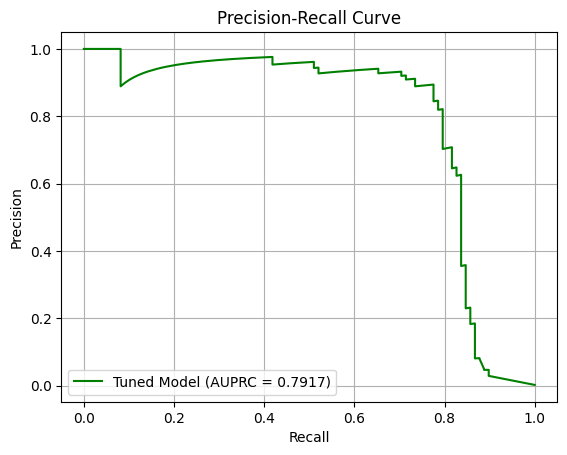


Confusion Matrix with Adjusted Threshold:
 [[56821    42]
 [   18    80]]

Classification Report with Adjusted Threshold:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.66      0.82      0.73        98

    accuracy                           1.00     56961
   macro avg       0.83      0.91      0.86     56961
weighted avg       1.00      1.00      1.00     56961


Test Set Confusion Matrix (Adjusted Threshold):
 [[56832    31]
 [   12    87]]

Test Set Classification Report (Adjusted Threshold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.74      0.88      0.80        99

    accuracy                           1.00     56962
   macro avg       0.87      0.94      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
#No smote , threshold =0.1 ,stratified split ,clas weight balanced
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import time

# File path for the dataset (Google Colab path)
file_path = '/content/drive/MyDrive/AppliedAIDataset/creditcard.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows
print(data.head())

# Check data summary
print(data.info())

# Check class imbalance
print(data['Class'].value_counts())

# Plotting the imbalance data
data['Class'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

# Separate features (X) and target (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Step 1: Split into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# Step 2: Split temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Verify the splits
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation set class distribution:\n", y_val.value_counts(normalize=True))
print("\nTesting set class distribution:\n", y_test.value_counts(normalize=True))

# Normalize feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [200],
    'max_depth': [20],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'class_weight': ['balanced']
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV for Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='average_precision',  # Optimize for AUPRC
    n_jobs=-1,
    verbose=3
)

# Track execution time
start_time = time.time()

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Track execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Grid Search Execution Time: {execution_time:.2f} seconds")

# Log best parameters and performance
print("Best Parameters from GridSearchCV:", grid_search.best_params_)
print("Best AUPRC from GridSearchCV:", grid_search.best_score_)

# Evaluate the best model on the validation data
best_rf_model = grid_search.best_estimator_
y_val_pred = best_rf_model.predict(X_val_scaled)
y_val_proba = best_rf_model.predict_proba(X_val_scaled)[:, 1]

# Confusion Matrix and Classification Report
print("\nTuned Model Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nTuned Model Classification Report:\n", classification_report(y_val, y_val_pred))

# ROC-AUC and AUPRC
roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"Tuned Model ROC-AUC Score: {roc_auc:.4f}")
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
tuned_auprc = auc(recall, precision)
print(f"Tuned Model AUPRC: {tuned_auprc:.4f}")

# Plot Precision-Recall Curve
plt.plot(recall, precision, label=f"Tuned Model (AUPRC = {tuned_auprc:.4f})", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Adjust Decision Threshold
optimal_threshold = 0.1  # Lower threshold to prioritize recall
y_val_pred_adjusted = (y_val_proba >= optimal_threshold).astype(int)

# Confusion Matrix and Classification Report for Adjusted Threshold
print("\nConfusion Matrix with Adjusted Threshold:\n", confusion_matrix(y_val, y_val_pred_adjusted))
print("\nClassification Report with Adjusted Threshold:\n", classification_report(y_val, y_val_pred_adjusted))

# Test the tuned model on the test set
y_test_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred_adjusted = (y_test_proba >= optimal_threshold).astype(int)

# Test Set Evaluation with Adjusted Threshold
print("\nTest Set Confusion Matrix (Adjusted Threshold):\n", confusion_matrix(y_test, y_test_pred_adjusted))
print("\nTest Set Classification Report (Adjusted Threshold):\n", classification_report(y_test, y_test_pred_adjusted))


In [ ]:
!pip install imbalanced-learn


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

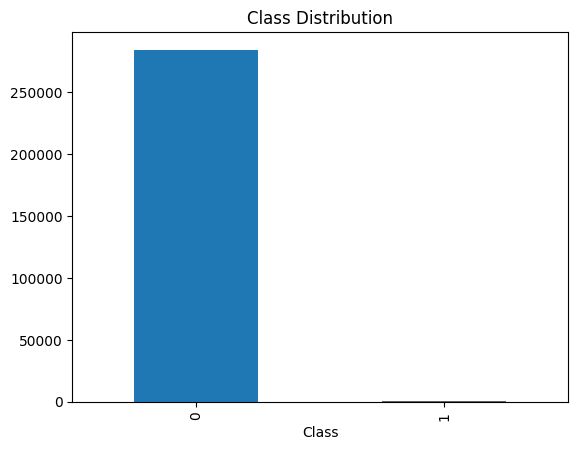

Training set class distribution:
 Class
0    0.998274
1    0.001726
Name: proportion, dtype: float64

Validation set class distribution:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

Testing set class distribution:
 Class
0    0.998262
1    0.001738
Name: proportion, dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



Balanced Training set class distribution after SMOTE:
 Class
0    170589
1    170589
Name: count, dtype: int64
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Grid Search Execution Time: 1994.03 seconds
Best Parameters from GridSearchCV: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best AUPRC from GridSearchCV: 0.9999958983785624

Tuned Model Confusion Matrix:
 [[56846    17]
 [   22    76]]

Tuned Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.82      0.78      0.80        98

    accuracy                           1.00     56961
   macro avg       0.91      0.89      0.90     56961
weighted avg       1.00      1.00      1.00     56961

Tuned Model ROC-AUC Score: 0.9743
Tuned Model AUPRC: 0.8101


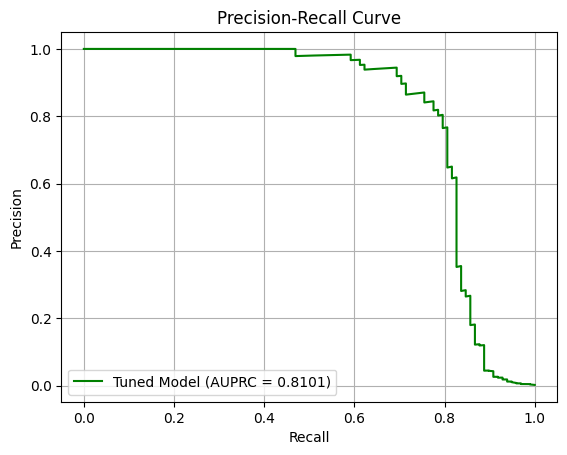

In [ ]:
#Smote, Default threshold
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import time

# File path for the dataset (Google Colab path)
file_path = '/content/drive/MyDrive/AppliedAIDataset/creditcard.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows
print(data.head())

# Check data summary
print(data.info())

# Check class imbalance
print(data['Class'].value_counts())

# Plotting the imbalance data
data['Class'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

# Separate features (X) and target (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Step 1: Split into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# Step 2: Split temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Verify the splits
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation set class distribution:\n", y_val.value_counts(normalize=True))
print("\nTesting set class distribution:\n", y_test.value_counts(normalize=True))

# Normalize feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Verify the new class distribution
print("\nBalanced Training set class distribution after SMOTE:\n", y_train_balanced.value_counts())

# Define hyperparameter grid
param_grid = {
    'n_estimators': [200],
    'max_depth': [20],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'class_weight': ['balanced']
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV for Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='average_precision',  # Optimize for AUPRC
    n_jobs=-1,
    verbose=3
)

# Track execution time
start_time = time.time()

# Fit the GridSearchCV to the balanced training data
grid_search.fit(X_train_balanced, y_train_balanced)

# Track execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Grid Search Execution Time: {execution_time:.2f} seconds")

# Log best parameters and performance
print("Best Parameters from GridSearchCV:", grid_search.best_params_)
print("Best AUPRC from GridSearchCV:", grid_search.best_score_)

# Evaluate the best model on the validation data
best_rf_model = grid_search.best_estimator_
y_val_pred = best_rf_model.predict(X_val_scaled)
y_val_proba = best_rf_model.predict_proba(X_val_scaled)[:, 1]

# Confusion Matrix and Classification Report
print("\nTuned Model Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nTuned Model Classification Report:\n", classification_report(y_val, y_val_pred))

# ROC-AUC and AUPRC
roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"Tuned Model ROC-AUC Score: {roc_auc:.4f}")
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
tuned_auprc = auc(recall, precision)
print(f"Tuned Model AUPRC: {tuned_auprc:.4f}")

# Plot Precision-Recall Curve
plt.plot(recall, precision, label=f"Tuned Model (AUPRC = {tuned_auprc:.4f})", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

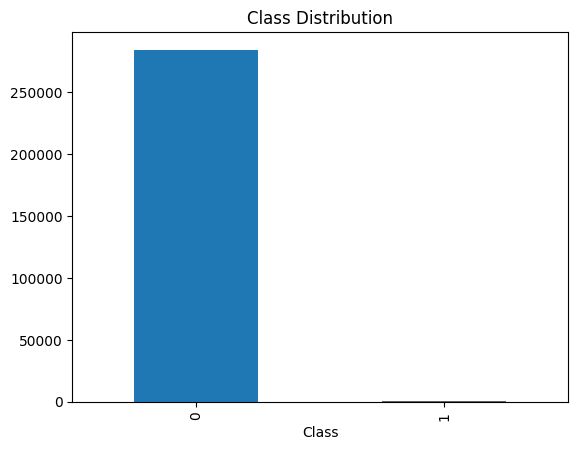

Training set class distribution:
 Class
0    0.998274
1    0.001726
Name: proportion, dtype: float64

Validation set class distribution:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

Testing set class distribution:
 Class
0    0.998262
1    0.001738
Name: proportion, dtype: float64
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Grid Search Execution Time: 587.56 seconds
Best Parameters from GridSearchCV: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best AUPRC from GridSearchCV: 0.8452492917742186

Tuned Model Confusion Matrix:
 [[56858     5]
 [   29    69]]

Tuned Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.70      0.80        98

    accuracy                           1.00     56961
   macro avg       0.97      0.85      0.90     56961
weighted avg       1.00 

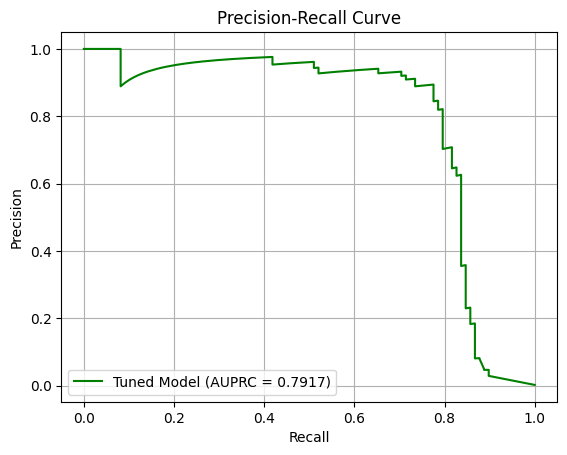


Confusion Matrix with Adjusted Threshold:
 [[56821    42]
 [   18    80]]

Classification Report with Adjusted Threshold:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.66      0.82      0.73        98

    accuracy                           1.00     56961
   macro avg       0.83      0.91      0.86     56961
weighted avg       1.00      1.00      1.00     56961


Test Set Confusion Matrix (Adjusted Threshold):
 [[56832    31]
 [   12    87]]

Test Set Classification Report (Adjusted Threshold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.74      0.88      0.80        99

    accuracy                           1.00     56962
   macro avg       0.87      0.94      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
#Adjusted threshold , no smote
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import time

# File path for the dataset (Google Colab path)
file_path = '/content/drive/MyDrive/AppliedAIDataset/creditcard.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows
print(data.head())

# Check data summary
print(data.info())

# Check class imbalance
print(data['Class'].value_counts())

# Plotting the imbalance data
data['Class'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

# Separate features (X) and target (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Step 1: Split into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# Step 2: Split temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Verify the splits
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation set class distribution:\n", y_val.value_counts(normalize=True))
print("\nTesting set class distribution:\n", y_test.value_counts(normalize=True))

# Normalize feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [200],
    'max_depth': [20],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'class_weight': ['balanced']
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV for Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='average_precision',  # Optimize for AUPRC
    n_jobs=-1,
    verbose=3
)

# Track execution time
start_time = time.time()

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Track execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Grid Search Execution Time: {execution_time:.2f} seconds")

# Log best parameters and performance
print("Best Parameters from GridSearchCV:", grid_search.best_params_)
print("Best AUPRC from GridSearchCV:", grid_search.best_score_)

# Evaluate the best model on the validation data
best_rf_model = grid_search.best_estimator_
y_val_pred = best_rf_model.predict(X_val_scaled)
y_val_proba = best_rf_model.predict_proba(X_val_scaled)[:, 1]

# Confusion Matrix and Classification Report
print("\nTuned Model Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nTuned Model Classification Report:\n", classification_report(y_val, y_val_pred))

# ROC-AUC and AUPRC
roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"Tuned Model ROC-AUC Score: {roc_auc:.4f}")
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
tuned_auprc = auc(recall, precision)
print(f"Tuned Model AUPRC: {tuned_auprc:.4f}")

# Plot Precision-Recall Curve
plt.plot(recall, precision, label=f"Tuned Model (AUPRC = {tuned_auprc:.4f})", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Adjust Decision Threshold
optimal_threshold = 0.1  # Lower threshold to prioritize recall
y_val_pred_adjusted = (y_val_proba >= optimal_threshold).astype(int)

# Confusion Matrix and Classification Report for Adjusted Threshold
print("\nConfusion Matrix with Adjusted Threshold:\n", confusion_matrix(y_val, y_val_pred_adjusted))
print("\nClassification Report with Adjusted Threshold:\n", classification_report(y_val, y_val_pred_adjusted))

# Test the tuned model on the test set
y_test_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred_adjusted = (y_test_proba >= optimal_threshold).astype(int)

# Test Set Evaluation with Adjusted Threshold
print("\nTest Set Confusion Matrix (Adjusted Threshold):\n", confusion_matrix(y_test, y_test_pred_adjusted))
print("\nTest Set Classification Report (Adjusted Threshold):\n", classification_report(y_test, y_test_pred_adjusted))


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

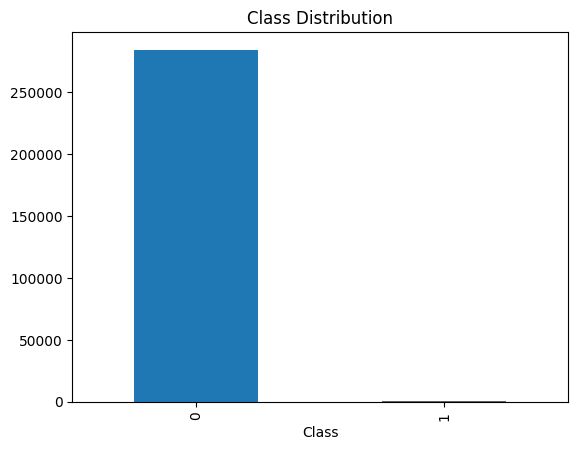

Training set class distribution:
 Class
0    0.998274
1    0.001726
Name: proportion, dtype: float64

Validation set class distribution:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

Testing set class distribution:
 Class
0    0.998262
1    0.001738
Name: proportion, dtype: float64
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Grid Search Execution Time: 633.83 seconds
Best Parameters from GridSearchCV: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best AUPRC from GridSearchCV: 0.8452492917742186

Tuned Model Confusion Matrix:
 [[56858     5]
 [   29    69]]

Tuned Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.70      0.80        98

    accuracy                           1.00     56961
   macro avg       0.97      0.85      0.90     56961
weighted avg       1.00 

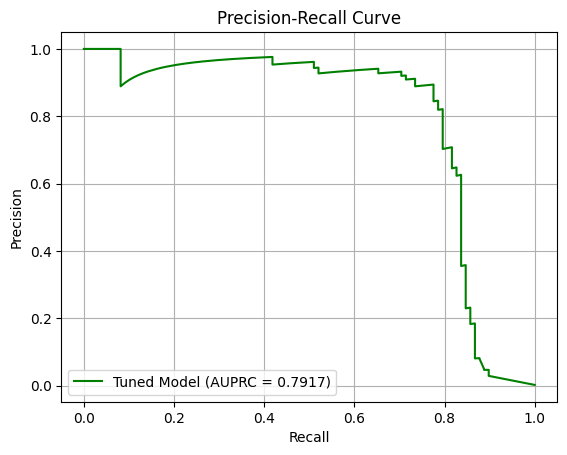

Optimized Threshold: 0.3447

Confusion Matrix with Optimized Threshold:
 [[56854     9]
 [   22    76]]

Classification Report with Optimized Threshold:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.89      0.78      0.83        98

    accuracy                           1.00     56961
   macro avg       0.95      0.89      0.92     56961
weighted avg       1.00      1.00      1.00     56961


Test Set Confusion Matrix (Optimized Threshold):
 [[56855     8]
 [   18    81]]

Test Set Classification Report (Optimized Threshold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.82      0.86        99

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Test Set ROC-AUC (Optimized Threshold): 0.9619
Test Se

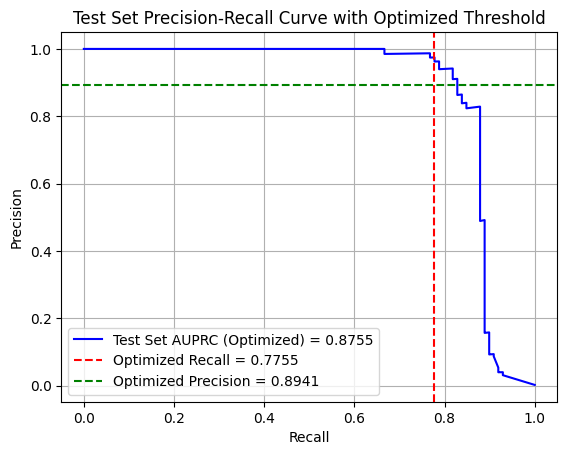

In [ ]:
#Optimized threshold, No smote
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import time

# File path for the dataset (Google Colab path)
file_path = '/content/drive/MyDrive/AppliedAIDataset/creditcard.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows
print(data.head())

# Check data summary
print(data.info())

# Check class imbalance
print(data['Class'].value_counts())

# Plotting the imbalance data
data['Class'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

# Separate features (X) and target (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Step 1: Split into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# Step 2: Split temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Verify the splits
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation set class distribution:\n", y_val.value_counts(normalize=True))
print("\nTesting set class distribution:\n", y_test.value_counts(normalize=True))

# Normalize feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [200],
    'max_depth': [20],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'class_weight': ['balanced']
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV for Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='average_precision',  # Optimize for AUPRC
    n_jobs=-1,
    verbose=3
)

# Track execution time
start_time = time.time()

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Track execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Grid Search Execution Time: {execution_time:.2f} seconds")

# Log best parameters and performance
print("Best Parameters from GridSearchCV:", grid_search.best_params_)
print("Best AUPRC from GridSearchCV:", grid_search.best_score_)

# Evaluate the best model on the validation data
best_rf_model = grid_search.best_estimator_
y_val_pred = best_rf_model.predict(X_val_scaled)
y_val_proba = best_rf_model.predict_proba(X_val_scaled)[:, 1]

# Confusion Matrix and Classification Report
print("\nTuned Model Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nTuned Model Classification Report:\n", classification_report(y_val, y_val_pred))

# ROC-AUC and AUPRC
roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"Tuned Model ROC-AUC Score: {roc_auc:.4f}")
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
tuned_auprc = auc(recall, precision)
print(f"Tuned Model AUPRC: {tuned_auprc:.4f}")

# Plot Precision-Recall Curve
plt.plot(recall, precision, label=f"Tuned Model (AUPRC = {tuned_auprc:.4f})", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Optimize Decision Threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimized Threshold: {optimal_threshold:.4f}")

# Confusion Matrix and Classification Report for Optimized Threshold
y_val_pred_optimized = (y_val_proba >= optimal_threshold).astype(int)
print("\nConfusion Matrix with Optimized Threshold:\n", confusion_matrix(y_val, y_val_pred_optimized))
print("\nClassification Report with Optimized Threshold:\n", classification_report(y_val, y_val_pred_optimized))

# Test the tuned model on the test set
y_test_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred_optimized = (y_test_proba >= optimal_threshold).astype(int)

# Test Set Evaluation with Optimized Threshold
print("\nTest Set Confusion Matrix (Optimized Threshold):\n", confusion_matrix(y_test, y_test_pred_optimized))
print("\nTest Set Classification Report (Optimized Threshold):\n", classification_report(y_test, y_test_pred_optimized))

roc_auc_test = roc_auc_score(y_test, y_test_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
auprc_test = auc(recall_test, precision_test)

print(f"Test Set ROC-AUC (Optimized Threshold): {roc_auc_test:.4f}")
print(f"Test Set AUPRC (Optimized Threshold): {auprc_test:.4f}")

# Test Set Accuracy
accuracy_test = accuracy_score(y_test, y_test_pred_optimized)
print(f"Test Set Accuracy (Optimized Threshold): {accuracy_test:.4f}")

# Plot Precision-Recall Curve for Test Set
plt.plot(recall_test, precision_test, label=f"Test Set AUPRC (Optimized) = {auprc_test:.4f}", color='blue')
plt.axvline(recall[optimal_idx], linestyle="--", color="red", label=f"Optimized Recall = {recall[optimal_idx]:.4f}")
plt.axhline(precision[optimal_idx], linestyle="--", color="green", label=f"Optimized Precision = {precision[optimal_idx]:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test Set Precision-Recall Curve with Optimized Threshold")
plt.legend()
plt.grid()
plt.show()


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

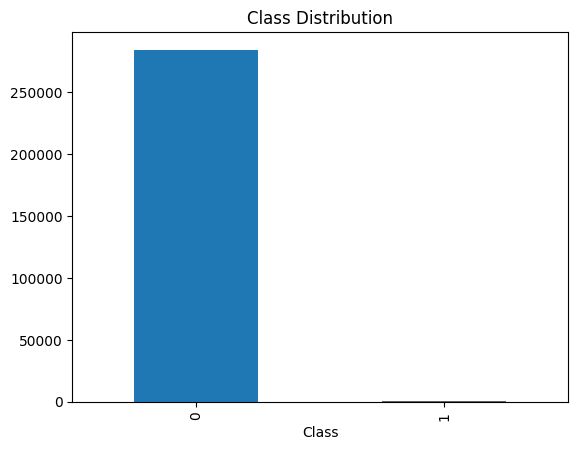

Training set class distribution:
 Class
0    0.998274
1    0.001726
Name: proportion, dtype: float64

Validation set class distribution:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

Testing set class distribution:
 Class
0    0.998262
1    0.001738
Name: proportion, dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



Balanced Training set class distribution:
 Class
0    170589
1    170589
Name: count, dtype: int64
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Grid Search Execution Time: 1840.48 seconds
Best Parameters from GridSearchCV: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best AUPRC from GridSearchCV: 0.9999958983785624

Tuned Model Confusion Matrix:
 [[56846    17]
 [   22    76]]

Tuned Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.82      0.78      0.80        98

    accuracy                           1.00     56961
   macro avg       0.91      0.89      0.90     56961
weighted avg       1.00      1.00      1.00     56961

Tuned Model ROC-AUC Score: 0.9743
Tuned Model AUPRC: 0.8101


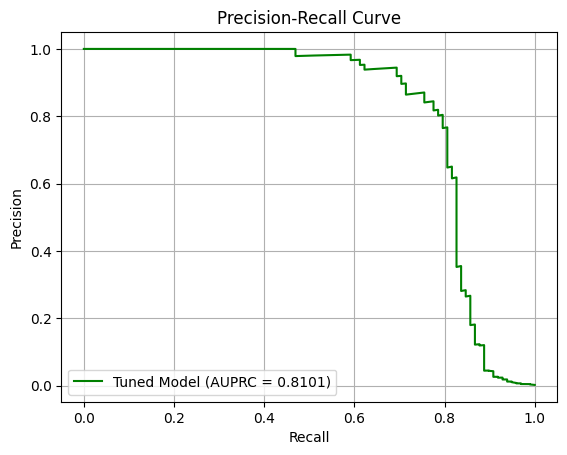

Optimized Threshold: 0.5897

Confusion Matrix with Optimized Threshold:
 [[56852    11]
 [   24    74]]

Classification Report with Optimized Threshold:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.87      0.76      0.81        98

    accuracy                           1.00     56961
   macro avg       0.94      0.88      0.90     56961
weighted avg       1.00      1.00      1.00     56961


Test Set Confusion Matrix (Optimized Threshold):
 [[56853    10]
 [   17    82]]

Test Set Classification Report (Optimized Threshold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.89      0.83      0.86        99

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Test Set ROC-AUC (Optimized Threshold): 0.9694
Test Se

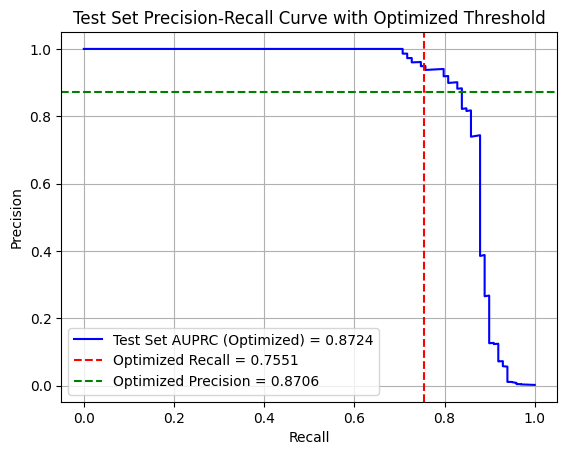

In [ ]:
#Same Code as above with SMOTE, These threshold optimization priorities f1-score
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import time

# File path for the dataset (Google Colab path)
file_path = '/content/drive/MyDrive/AppliedAIDataset/creditcard.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows
print(data.head())

# Check data summary
print(data.info())

# Check class imbalance
print(data['Class'].value_counts())

# Plotting the imbalance data
data['Class'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

# Separate features (X) and target (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Step 1: Split into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# Step 2: Split temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Verify the splits
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation set class distribution:\n", y_val.value_counts(normalize=True))
print("\nTesting set class distribution:\n", y_test.value_counts(normalize=True))

# Normalize feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Verify the new class distribution after SMOTE
print("\nBalanced Training set class distribution:\n", y_train_balanced.value_counts())

# Define hyperparameter grid
param_grid = {
    'n_estimators': [200],
    'max_depth': [20],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'class_weight': ['balanced']
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV for Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='average_precision',  # Optimize for AUPRC
    n_jobs=-1,
    verbose=3
)

# Track execution time
start_time = time.time()

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_balanced, y_train_balanced)

# Track execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Grid Search Execution Time: {execution_time:.2f} seconds")

# Log best parameters and performance
print("Best Parameters from GridSearchCV:", grid_search.best_params_)
print("Best AUPRC from GridSearchCV:", grid_search.best_score_)

# Evaluate the best model on the validation data
best_rf_model = grid_search.best_estimator_
y_val_pred = best_rf_model.predict(X_val_scaled)
y_val_proba = best_rf_model.predict_proba(X_val_scaled)[:, 1]

# Confusion Matrix and Classification Report
print("\nTuned Model Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nTuned Model Classification Report:\n", classification_report(y_val, y_val_pred))

# ROC-AUC and AUPRC
roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"Tuned Model ROC-AUC Score: {roc_auc:.4f}")
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
tuned_auprc = auc(recall, precision)
print(f"Tuned Model AUPRC: {tuned_auprc:.4f}")

# Plot Precision-Recall Curve
plt.plot(recall, precision, label=f"Tuned Model (AUPRC = {tuned_auprc:.4f})", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Optimize Decision Threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimized Threshold: {optimal_threshold:.4f}")

# Confusion Matrix and Classification Report for Optimized Threshold
y_val_pred_optimized = (y_val_proba >= optimal_threshold).astype(int)
print("\nConfusion Matrix with Optimized Threshold:\n", confusion_matrix(y_val, y_val_pred_optimized))
print("\nClassification Report with Optimized Threshold:\n", classification_report(y_val, y_val_pred_optimized))

# Test the tuned model on the test set
y_test_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred_optimized = (y_test_proba >= optimal_threshold).astype(int)

# Test Set Evaluation with Optimized Threshold
print("\nTest Set Confusion Matrix (Optimized Threshold):\n", confusion_matrix(y_test, y_test_pred_optimized))
print("\nTest Set Classification Report (Optimized Threshold):\n", classification_report(y_test, y_test_pred_optimized))

roc_auc_test = roc_auc_score(y_test, y_test_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
auprc_test = auc(recall_test, precision_test)

print(f"Test Set ROC-AUC (Optimized Threshold): {roc_auc_test:.4f}")
print(f"Test Set AUPRC (Optimized Threshold): {auprc_test:.4f}")

# Test Set Accuracy
accuracy_test = accuracy_score(y_test, y_test_pred_optimized)
print(f"Test Set Accuracy (Optimized Threshold): {accuracy_test:.4f}")

# Plot Precision-Recall Curve for Test Set
plt.plot(recall_test, precision_test, label=f"Test Set AUPRC (Optimized) = {auprc_test:.4f}", color='blue')
plt.axvline(recall[optimal_idx], linestyle="--", color="red", label=f"Optimized Recall = {recall[optimal_idx]:.4f}")
plt.axhline(precision[optimal_idx], linestyle="--", color="green", label=f"Optimized Precision = {precision[optimal_idx]:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test Set Precision-Recall Curve with Optimized Threshold")
plt.legend()
plt.grid()
plt.show()


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

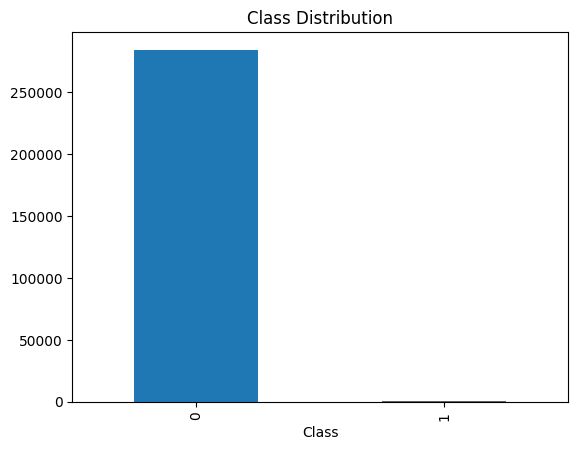

Training set class distribution:
 Class
0    0.998274
1    0.001726
Name: proportion, dtype: float64

Validation set class distribution:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

Testing set class distribution:
 Class
0    0.998262
1    0.001738
Name: proportion, dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



Balanced Training set class distribution:
 Class
0    170589
1    170589
Name: count, dtype: int64
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Grid Search Execution Time: 2149.36 seconds
Best Parameters from GridSearchCV: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best AUPRC from GridSearchCV: 0.9999958983785624

Tuned Model Confusion Matrix:
 [[56846    17]
 [   22    76]]

Tuned Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.82      0.78      0.80        98

    accuracy                           1.00     56961
   macro avg       0.91      0.89      0.90     56961
weighted avg       1.00      1.00      1.00     56961

Tuned Model ROC-AUC Score: 0.9743
Tuned Model AUPRC: 0.8101


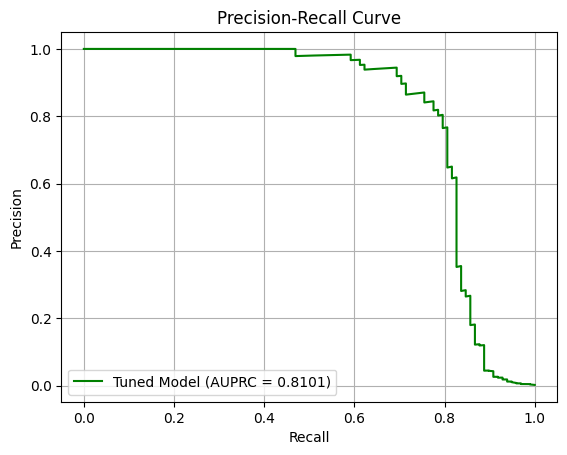

Optimized Threshold for Maximum Recall: 0.0000
Optimized Threshold for Recall with Precision >= 0.80: 0.4764

Confusion Matrix with Optimized Threshold for Recall:
 [[56844    19]
 [   20    78]]

Classification Report with Optimized Threshold for Recall:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.80      0.80      0.80        98

    accuracy                           1.00     56961
   macro avg       0.90      0.90      0.90     56961
weighted avg       1.00      1.00      1.00     56961


Test Set Confusion Matrix (Optimized Threshold for Recall):
 [[56849    14]
 [   16    83]]

Test Set Classification Report (Optimized Threshold for Recall):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.86      0.84      0.85        99

    accuracy                           1.00     56962
   macro avg       0.93      0.92     

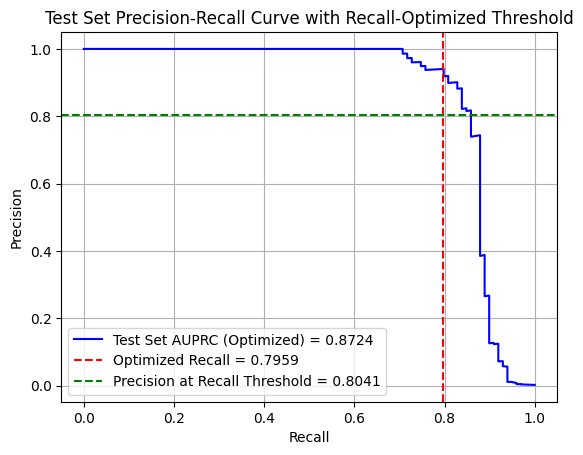

In [ ]:
#Same code as above with threshold adjusted for recall
#Best
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import time

# File path for the dataset (Google Colab path)
file_path = '/content/drive/MyDrive/AppliedAIDataset/creditcard.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows
print(data.head())

# Check data summary
print(data.info())

# Check class imbalance
print(data['Class'].value_counts())

# Plotting the imbalance data
data['Class'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

# Separate features (X) and target (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Step 1: Split into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# Step 2: Split temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Verify the splits
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation set class distribution:\n", y_val.value_counts(normalize=True))
print("\nTesting set class distribution:\n", y_test.value_counts(normalize=True))

# Normalize feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Verify the new class distribution after SMOTE
print("\nBalanced Training set class distribution:\n", y_train_balanced.value_counts())

# Define hyperparameter grid
param_grid = {
    'n_estimators': [200],
    'max_depth': [20],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'class_weight': ['balanced']
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV for Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='average_precision',  # Optimize for AUPRC
    n_jobs=-1,
    verbose=3
)

# Track execution time
start_time = time.time()

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_balanced, y_train_balanced)

# Track execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Grid Search Execution Time: {execution_time:.2f} seconds")

# Log best parameters and performance
print("Best Parameters from GridSearchCV:", grid_search.best_params_)
print("Best AUPRC from GridSearchCV:", grid_search.best_score_)

# Evaluate the best model on the validation data
best_rf_model = grid_search.best_estimator_
y_val_pred = best_rf_model.predict(X_val_scaled)
y_val_proba = best_rf_model.predict_proba(X_val_scaled)[:, 1]

# Confusion Matrix and Classification Report
print("\nTuned Model Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nTuned Model Classification Report:\n", classification_report(y_val, y_val_pred))

# ROC-AUC and AUPRC
roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"Tuned Model ROC-AUC Score: {roc_auc:.4f}")
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
tuned_auprc = auc(recall, precision)
print(f"Tuned Model AUPRC: {tuned_auprc:.4f}")

# Plot Precision-Recall Curve
plt.plot(recall, precision, label=f"Tuned Model (AUPRC = {tuned_auprc:.4f})", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Optimize Decision Threshold for Recall
# Option 1: Maximize Recall
optimal_idx = np.argmax(recall)  # Find the threshold with the highest recall
optimal_threshold = thresholds[optimal_idx]
print(f"Optimized Threshold for Maximum Recall: {optimal_threshold:.4f}")

# Option 2: Recall with Minimum Precision Constraint (optional)
min_precision = 0.80  # Example: Require at least 80% precision
indices = np.where(precision >= min_precision)[0]
if len(indices) > 0:
    optimal_idx = indices[np.argmax(recall[indices])]
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimized Threshold for Recall with Precision >= {min_precision:.2f}: {optimal_threshold:.4f}")
else:
    print(f"No threshold meets the minimum precision requirement of {min_precision:.2f}.")

# Confusion Matrix and Classification Report for Optimized Threshold
y_val_pred_optimized = (y_val_proba >= optimal_threshold).astype(int)
print("\nConfusion Matrix with Optimized Threshold for Recall:\n", confusion_matrix(y_val, y_val_pred_optimized))
print("\nClassification Report with Optimized Threshold for Recall:\n", classification_report(y_val, y_val_pred_optimized))

# Test the tuned model on the test set
y_test_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred_optimized = (y_test_proba >= optimal_threshold).astype(int)

# Test Set Evaluation with Optimized Threshold for Recall
print("\nTest Set Confusion Matrix (Optimized Threshold for Recall):\n", confusion_matrix(y_test, y_test_pred_optimized))
print("\nTest Set Classification Report (Optimized Threshold for Recall):\n", classification_report(y_test, y_test_pred_optimized))

roc_auc_test = roc_auc_score(y_test, y_test_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
auprc_test = auc(recall_test, precision_test)

print(f"Test Set ROC-AUC (Optimized Threshold): {roc_auc_test:.4f}")
print(f"Test Set AUPRC (Optimized Threshold): {auprc_test:.4f}")

# Test Set Accuracy
accuracy_test = accuracy_score(y_test, y_test_pred_optimized)
print(f"Test Set Accuracy (Optimized Threshold): {accuracy_test:.4f}")

# Plot Precision-Recall Curve for Test Set
plt.plot(recall_test, precision_test, label=f"Test Set AUPRC (Optimized) = {auprc_test:.4f}", color='blue')
plt.axvline(recall[optimal_idx], linestyle="--", color="red", label=f"Optimized Recall = {recall[optimal_idx]:.4f}")
plt.axhline(precision[optimal_idx], linestyle="--", color="green", label=f"Precision at Recall Threshold = {precision[optimal_idx]:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test Set Precision-Recall Curve with Recall-Optimized Threshold")
plt.legend()
plt.grid()
plt.show()


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

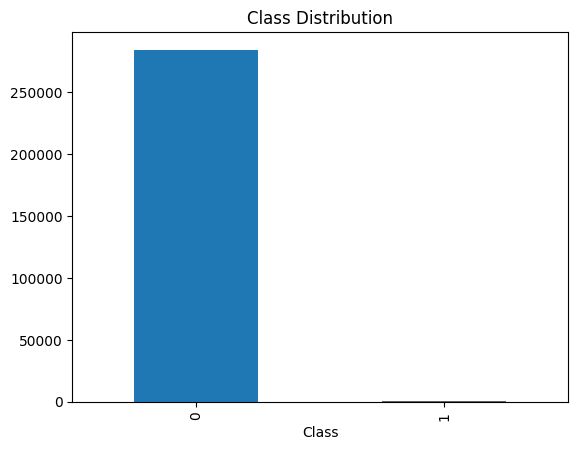

Training set class distribution:
 Class
0    0.998274
1    0.001726
Name: proportion, dtype: float64

Validation set class distribution:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

Testing set class distribution:
 Class
0    0.998262
1    0.001738
Name: proportion, dtype: float64
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sk

Grid Search Execution Time: 3307.18 seconds
Best Parameters from GridSearchCV: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best AUPRC from GridSearchCV: 0.8365996739284409

Tuned Model Confusion Matrix:
 [[56846    17]
 [   22    76]]

Tuned Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.82      0.78      0.80        98

    accuracy                           1.00     56961
   macro avg       0.91      0.89      0.90     56961
weighted avg       1.00      1.00      1.00     56961

Tuned Model ROC-AUC Score: 0.9743
Tuned Model AUPRC: 0.8101


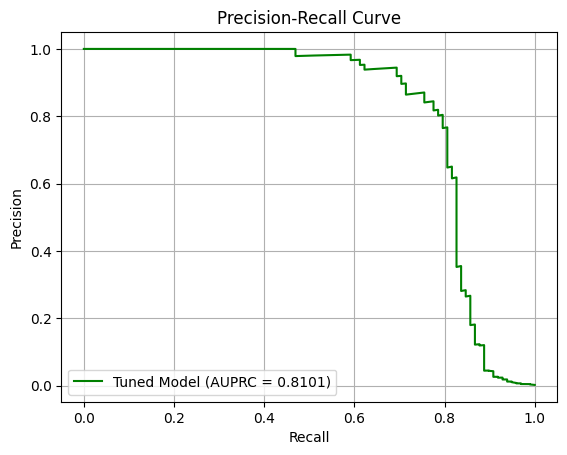

Optimized Threshold: 0.5897

Confusion Matrix with Optimized Threshold:
 [[56852    11]
 [   24    74]]

Classification Report with Optimized Threshold:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.87      0.76      0.81        98

    accuracy                           1.00     56961
   macro avg       0.94      0.88      0.90     56961
weighted avg       1.00      1.00      1.00     56961


Test Set Confusion Matrix (Optimized Threshold):
 [[56853    10]
 [   17    82]]

Test Set Classification Report (Optimized Threshold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.89      0.83      0.86        99

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Test Set ROC-AUC (Optimized Threshold): 0.9694
Test Se

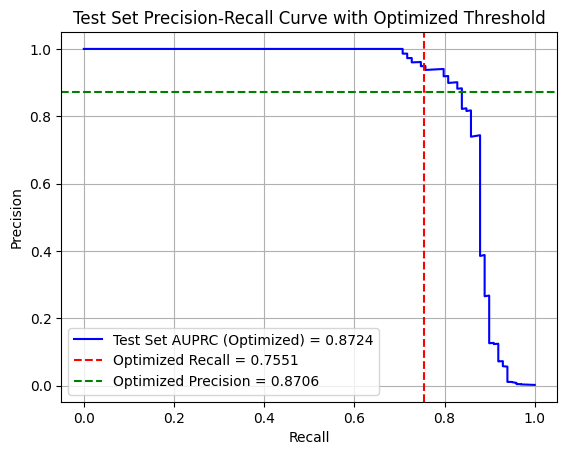

In [ ]:
#Same code as above but to prevent data leakage  the oversampling process is applied within each fold separately. This ensures that the synthetic samples generated by SMOTE during training do not "leak" into the validation set, which could lead to overly optimistic performance estimates.
#Cv = 5  for 5 cross validation
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import numpy as np
import time

# File path for the dataset (Google Colab path)
file_path = '/content/drive/MyDrive/AppliedAIDataset/creditcard.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows
print(data.head())

# Check data summary
print(data.info())

# Check class imbalance
print(data['Class'].value_counts())

# Plotting the imbalance data
data['Class'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

# Separate features (X) and target (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Step 1: Split into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# Step 2: Split temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Verify the splits
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation set class distribution:\n", y_val.value_counts(normalize=True))
print("\nTesting set class distribution:\n", y_test.value_counts(normalize=True))

# Normalize feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the pipeline with SMOTE and RandomForestClassifier
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE
    ('classifier', RandomForestClassifier(random_state=42))  # Random Forest Classifier
])

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [200],
    'classifier__max_depth': [20],
    'classifier__min_samples_split': [5],
    'classifier__min_samples_leaf': [1],
    'classifier__class_weight': ['balanced']
}

# Set up Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='average_precision',  # Optimize for AUPRC
    cv=cv,
    verbose=3,
    n_jobs=-1
)

# Track execution time
start_time = time.time()

# Fit the pipeline using GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Track execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Grid Search Execution Time: {execution_time:.2f} seconds")

# Log best parameters and performance
print("Best Parameters from GridSearchCV:", grid_search.best_params_)
print("Best AUPRC from GridSearchCV:", grid_search.best_score_)

# Evaluate the best model on the validation data
best_rf_model = grid_search.best_estimator_
y_val_pred = best_rf_model.predict(X_val_scaled)
y_val_proba = best_rf_model.predict_proba(X_val_scaled)[:, 1]

# Confusion Matrix and Classification Report
print("\nTuned Model Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nTuned Model Classification Report:\n", classification_report(y_val, y_val_pred))

# ROC-AUC and AUPRC
roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"Tuned Model ROC-AUC Score: {roc_auc:.4f}")
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
tuned_auprc = auc(recall, precision)
print(f"Tuned Model AUPRC: {tuned_auprc:.4f}")

# Plot Precision-Recall Curve
plt.plot(recall, precision, label=f"Tuned Model (AUPRC = {tuned_auprc:.4f})", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Optimize Decision Threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimized Threshold: {optimal_threshold:.4f}")

# Confusion Matrix and Classification Report for Optimized Threshold
y_val_pred_optimized = (y_val_proba >= optimal_threshold).astype(int)
print("\nConfusion Matrix with Optimized Threshold:\n", confusion_matrix(y_val, y_val_pred_optimized))
print("\nClassification Report with Optimized Threshold:\n", classification_report(y_val, y_val_pred_optimized))

# Test the tuned model on the test set
y_test_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred_optimized = (y_test_proba >= optimal_threshold).astype(int)

# Test Set Evaluation with Optimized Threshold
print("\nTest Set Confusion Matrix (Optimized Threshold):\n", confusion_matrix(y_test, y_test_pred_optimized))
print("\nTest Set Classification Report (Optimized Threshold):\n", classification_report(y_test, y_test_pred_optimized))

roc_auc_test = roc_auc_score(y_test, y_test_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
auprc_test = auc(recall_test, precision_test)

print(f"Test Set ROC-AUC (Optimized Threshold): {roc_auc_test:.4f}")
print(f"Test Set AUPRC (Optimized Threshold): {auprc_test:.4f}")

# Test Set Accuracy
accuracy_test = accuracy_score(y_test, y_test_pred_optimized)
print(f"Test Set Accuracy (Optimized Threshold): {accuracy_test:.4f}")

# Plot Precision-Recall Curve for Test Set
plt.plot(recall_test, precision_test, label=f"Test Set AUPRC (Optimized) = {auprc_test:.4f}", color='blue')
plt.axvline(recall[optimal_idx], linestyle="--", color="red", label=f"Optimized Recall = {recall[optimal_idx]:.4f}")
plt.axhline(precision[optimal_idx], linestyle="--", color="green", label=f"Optimized Precision = {precision[optimal_idx]:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test Set Precision-Recall Curve with Optimized Threshold")
plt.legend()
plt.grid()
plt.show()
